# 1. Imports & Setup

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


from gensim.models import Word2Vec


SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 2. Load Dataset

In [15]:
df = pd.read_csv("/kaggle/input/pricerunner/pricerunner_aggregate.csv")
df.head()

,Product ID,Product Title,Merchant ID,Cluster ID,Cluster Label,Category ID,Category Label
0,1,apple iphone 8 plus 64gb silver,1,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
1,2,apple iphone 8 plus 64 gb spacegrau,2,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
2,3,apple mq8n2b/a iphone 8 plus 64gb 5.5 12mp sim...,3,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
3,4,apple iphone 8 plus 64gb space grey,4,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones
4,5,apple iphone 8 plus gold 5.5 64gb 4g unlocked ...,5,1,Apple iPhone 8 Plus 64GB,2612,Mobile Phones


# 3. Basic Preprocessing

In [16]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
print(df.columns)


Index(['product_id', 'product_title', 'merchant_id', 'cluster_id',
       'cluster_label', 'category_id', 'category_label'],
      dtype='object')


# 4. Train-Test Split

In [17]:
texts = df["product_title"].astype(str).values
labels = df["category_label"].values

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

num_classes = len(np.unique(y))

X_train_text, X_test_text, y_train, y_test = train_test_split(
    texts,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

y_train_cat = to_categorical(y_train, num_classes)
y_test_cat = to_categorical(y_test, num_classes)


# 5. Dataset Exploration

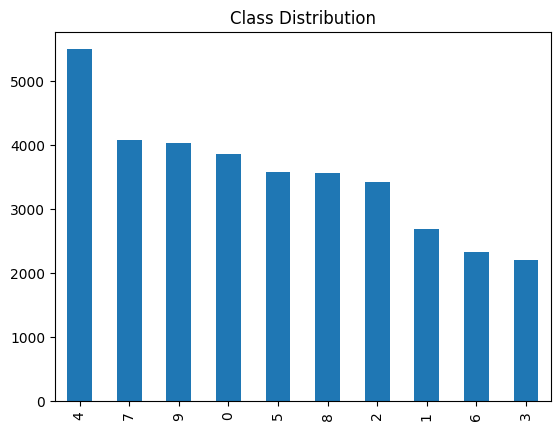

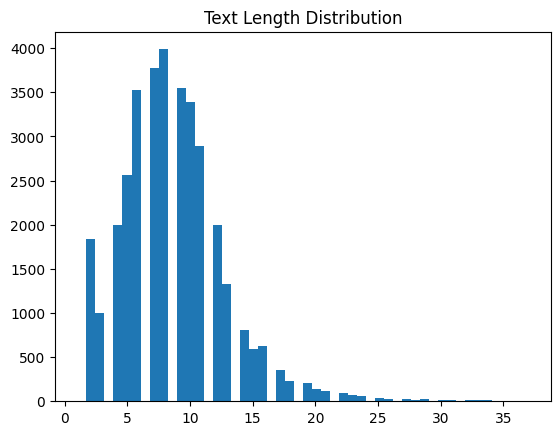

In [18]:
plt.figure()
pd.Series(y).value_counts().plot(kind='bar')
plt.title("Class Distribution")
plt.show()


text_lengths = [len(t.split()) for t in texts]
plt.figure()
plt.hist(text_lengths, bins=50)
plt.title("Text Length Distribution")
plt.show()

In [19]:
import pickle

best_model = None
best_tokenizer = None
best_embedding_name = None
best_f1 = 0.0


# 6. GRU with TF-IDF

In [20]:
print("\n--- GRU with TF-IDF ---")


max_features = 10000


tfidf = TfidfVectorizer(max_features=max_features)
X_train_tfidf = tfidf.fit_transform(X_train_text).toarray()
X_test_tfidf = tfidf.transform(X_test_text).toarray()


# Expand dims for GRU (timesteps=1)
X_train_tfidf = np.expand_dims(X_train_tfidf, axis=1)
X_test_tfidf = np.expand_dims(X_test_tfidf, axis=1)


model_tfidf = Sequential([
GRU(128, input_shape=(1, max_features)),
Dropout(0.5),
Dense(num_classes, activation='softmax')
])


model_tfidf.compile(
optimizer='adam',
loss='categorical_crossentropy',
metrics=['accuracy']
)


model_tfidf.fit(
X_train_tfidf,
y_train_cat,
validation_split=0.1,
epochs=10,
batch_size=64
)

pred_tfidf = np.argmax(model_tfidf.predict(X_test_tfidf), axis=1)
print(classification_report(y_test, pred_tfidf))



--- GRU with TF-IDF ---


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10


I0000 00:00:1770577989.195958     141 cuda_dnn.cc:529] Loaded cuDNN version 91002


398/398 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.6775 - loss: 1.5333 - val_accuracy: 0.9455 - val_loss: 0.2714
Epoch 2/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9612 - loss: 0.2122 - val_accuracy: 0.9692 - val_loss: 0.1504
Epoch 3/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9815 - loss: 0.1080 - val_accuracy: 0.9773 - val_loss: 0.1155
Epoch 4/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9876 - loss: 0.0692 - val_accuracy: 0.9798 - val_loss: 0.1003
Epoch 5/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9900 - loss: 0.0492 - val_accuracy: 0.9805 - val_loss: 0.0930
Epoch 6/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9904 - loss: 0.0392 - val_accuracy: 0.9809 - val_loss: 0.0886
Epoch 7/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9909 - loss: 0.0334 - val_accuracy: 0.9819 - val_loss: 0.0862
Epoch 8/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9922 - loss: 0.0284 - val_accuracy: 0.9802 - val_

# 7. Tokenization for Word2Vec

In [21]:
max_words = 20000
max_len = 20


tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)


X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_test_seq = tokenizer.texts_to_sequences(X_test_text)


X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


word_index = tokenizer.word_index
vocab_size = min(max_words, len(word_index) + 1)

# 8. Word2Vec Training (Skip-gram & CBOW)

In [22]:
train_tokens = [text.split() for text in X_train_text]


w2v_skip = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    sg=1,
    workers=4,
    seed=SEED
)


w2v_cbow = Word2Vec(
    sentences=train_tokens,
    vector_size=100,
    window=5,
    min_count=2,
    sg=0,
    workers=4,
    seed=SEED
)


def build_embedding_matrix(w2v_model):
    embedding_matrix = np.zeros((vocab_size, 100))
    for word, idx in word_index.items():
        if idx < vocab_size and word in w2v_model.wv:
            embedding_matrix[idx] = w2v_model.wv[word]
    return embedding_matrix


embedding_skip = build_embedding_matrix(w2v_skip)
embedding_cbow = build_embedding_matrix(w2v_cbow)

# 9. GRU Model Builder

In [23]:
def build_gru_model(embedding_matrix):
    model = Sequential([
        Embedding(
            input_dim=vocab_size,
            output_dim=100,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=False
        ),
        GRU(128),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# 10. GRU + Skip-gram

In [24]:
print("\n--- GRU with Word2Vec Skip-gram ---")
model_skip = build_gru_model(embedding_skip)
model_skip.fit(
    X_train_pad,
    y_train_cat,
    validation_split=0.1,
    epochs=10,
    batch_size=64
)


pred_skip = np.argmax(model_skip.predict(X_test_pad), axis=1)
print(classification_report(y_test, pred_skip))


--- GRU with Word2Vec Skip-gram ---
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


398/398 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5061 - loss: 1.2982 - val_accuracy: 0.8832 - val_loss: 0.3064
Epoch 2/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8946 - loss: 0.2888 - val_accuracy: 0.9335 - val_loss: 0.1955
Epoch 3/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9348 - loss: 0.1952 - val_accuracy: 0.9398 - val_loss: 0.1777
Epoch 4/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9405 - loss: 0.1752 - val_accuracy: 0.9458 - val_loss: 0.1622
Epoch 5/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9466 - loss: 0.1562 - val_accuracy: 0.9458 - val_loss: 0.1569
Epoch 6/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9494 - loss: 0.1444 - val_accuracy: 0.9501 - val_loss: 0.1447
Epoch 7/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9538 - loss: 0.1329 - val_accuracy: 0.9522 - val_loss: 0.1422
Epoch 8/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9538 - loss: 0.1259 - val_accuracy: 0.9504 - val_

# 11. GRU + CBOW

In [25]:
print("\n--- GRU with Word2Vec CBOW ---")
model_cbow = build_gru_model(embedding_cbow)
model_cbow.fit(
    X_train_pad,
    y_train_cat,
    validation_split=0.1,
    epochs=10,
    batch_size=64
)


pred_cbow = np.argmax(model_cbow.predict(X_test_pad), axis=1)
print(classification_report(y_test, pred_cbow))


--- GRU with Word2Vec CBOW ---
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


398/398 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.5141 - loss: 1.3062 - val_accuracy: 0.9002 - val_loss: 0.2838
Epoch 2/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9126 - loss: 0.2619 - val_accuracy: 0.9267 - val_loss: 0.2305
Epoch 3/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9255 - loss: 0.2226 - val_accuracy: 0.9296 - val_loss: 0.2125
Epoch 4/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9287 - loss: 0.2036 - val_accuracy: 0.9331 - val_loss: 0.1957
Epoch 5/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9340 - loss: 0.1834 - val_accuracy: 0.9405 - val_loss: 0.1810
Epoch 6/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9377 - loss: 0.1752 - val_accuracy: 0.9373 - val_loss: 0.1848
Epoch 7/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9401 - loss: 0.1657 - val_accuracy: 0.9395 - val_loss: 0.1773
Epoch 8/10
398/398 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9448 - loss: 0.1584 - val_accuracy: 0.9409 - val_

# 12. Summary Table

In [26]:
results = pd.DataFrame({
    'Model': ['GRU'],
    'TF-IDF': [accuracy_score(y_test, pred_tfidf)],
    'Skip-gram': [accuracy_score(y_test, pred_skip)],
    'CBOW': [accuracy_score(y_test, pred_cbow)]
})


print(results)

  Model    TF-IDF  Skip-gram      CBOW
0   GRU  0.974657   0.951295  0.942517


In [27]:
best_embedding = results.drop(columns=["Model"]).idxmax(axis=1).values[0]
best_score = results.drop(columns=["Model"]).max(axis=1).values[0]

print(f"Best model: GRU + {best_embedding} (Accuracy = {best_score:.4f})")


Best model: GRU + TF-IDF (Accuracy = 0.9747)


# 13. Confusion Matrices for all Embeddings

In [29]:
def plot_confusion_matrix(model, X_test, y_test, title):
    # Predict
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_classes)

    # Plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues", xticks_rotation=45)
    plt.title(title)
    plt.show()


221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


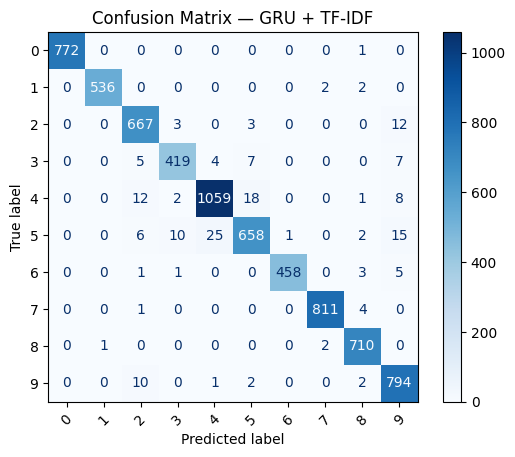

In [32]:
plot_confusion_matrix(
    model=model_tfidf,
    X_test=X_test_tfidf,
    y_test=y_test,
    title="Confusion Matrix — GRU + TF-IDF"
)


221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


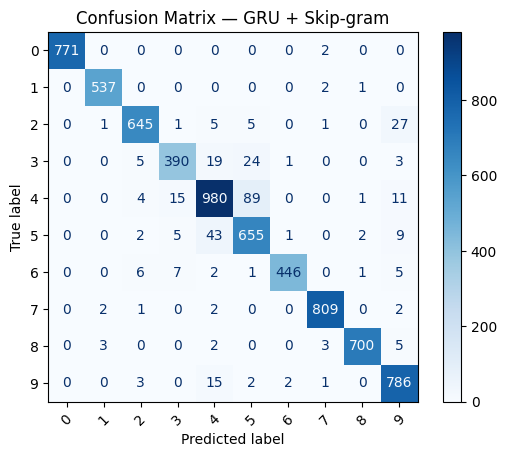

In [36]:
plot_confusion_matrix(
    model=model_skip,
    X_test=X_test_pad,
    y_test=y_test,
    title="Confusion Matrix — GRU + Skip-gram"
)


221/221 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


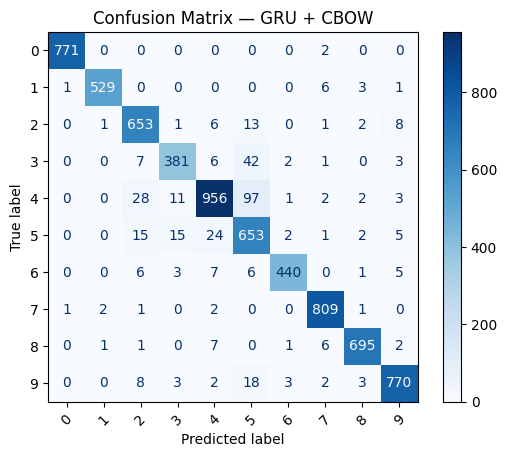

In [38]:
plot_confusion_matrix(
    model=model_cbow,
    X_test=X_test_pad,
    y_test=y_test,
    title="Confusion Matrix — GRU + CBOW"
)
